## Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



from google.colab import drive
drive.mount('/content/drive')



train_df = pd.read_csv('/content/drive/My Drive/data/train.csv')
store_df = pd.read_csv('/content/drive/My Drive/data/store.csv')




# # Load data
# train_df = pd.read_csv('../assets/datas/train.csv')
# store_df = pd.read_csv('../assets/datas/store.csv')

# Merge data
data = pd.merge(train_df, store_df, on='Store')

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Extract new features from Date
data['Weekday'] = data['Date'].dt.weekday
data['Weekend'] = data['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Year'] = data['Date'].dt.year
data['WeekOfYear'] = data['Date'].dt.isocalendar().week

# Example: Days to next holiday (assuming holidays are known)
holidays = pd.to_datetime(['2023-12-25', '2023-01-01'])  # Add more holidays as needed
data['DaysToHoliday'] = data['Date'].apply(lambda x: (holidays - x).days.min())

# Handle NaN values
data.fillna(0, inplace=True)

# Convert categorical columns to numeric
data = pd.get_dummies(data, columns=['StoreType', 'Assortment', 'StateHoliday'])

# Drop columns that won't be used
data.drop(['Date', 'Customers'], axis=1, inplace=True)

# Ensure all columns are numeric
non_numeric_columns = data.select_dtypes(include=['object']).columns
if not non_numeric_columns.empty:
    print(f"Non-numeric columns found: {non_numeric_columns.tolist()}")

# Convert any remaining non-numeric columns to numeric
# Example: Handling 'PromoInterval'
if 'PromoInterval' in data.columns:
    data['PromoInterval'] = data['PromoInterval'].apply(
        lambda x: 0 if x == 0 else len(x.split(',')) if isinstance(x, str) else 0
    )

# Split data into features and target
X = data.drop('Sales', axis=1)
y = data['Sales']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-1-fb0b35d5d4f0>:13: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/drive/My Drive/data/train.csv')


Non-numeric columns found: ['PromoInterval']


## Building Models with Sklearn Pipelines

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Initialize the XGBRegressor with optimized parameters
regressor = XGBRegressor(
    n_estimators=25,  # Reduced number of estimators
    max_depth=7,     # Reduced tree depth
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,         # Use all CPU cores
    tree_method='hist', # Faster tree method
    #subsample=0.8 # Subsample data for faster training (optional)
)


# Train and evaluate with early stopping and a validation set
regressor.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
y_pred = regressor.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error with XGBoost: {mse}')


Mean Squared Error with XGBoost: 4897745.5


## Post Prediction Analysis

## Feature Importance: Analyze which features contribute most to the predictions.

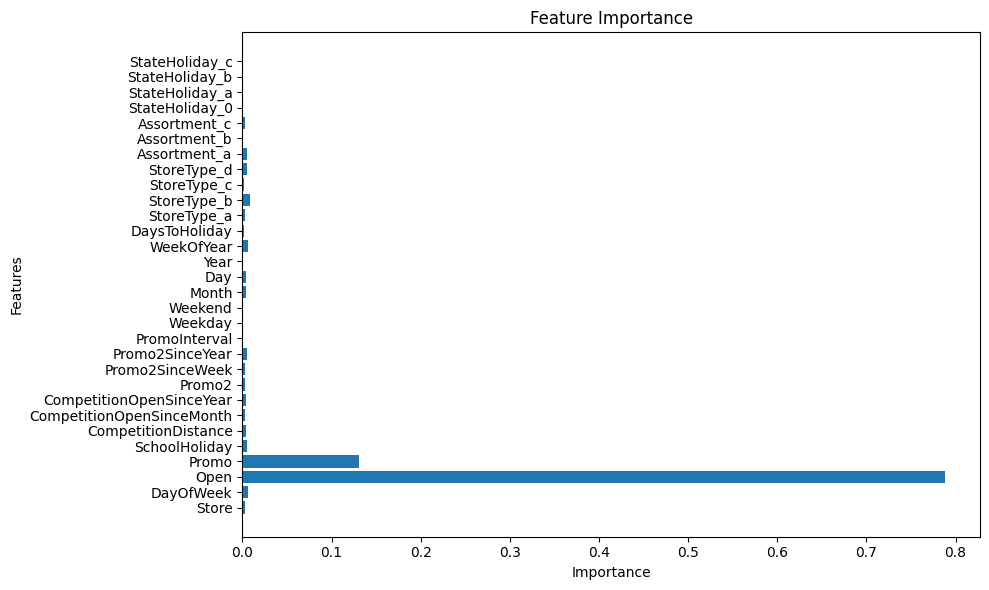

In [4]:
import matplotlib.pyplot as plt

feature_importance = regressor.feature_importances_  # Access feature importance directly
features = X.columns

plt.figure(figsize=(10, 6)) # Adjust figure size for better visibility
plt.barh(features, feature_importance)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


## Confidence Interval: Use bootstrapping to estimate prediction intervals.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0
1
2
3
4
5
6
7
8
9


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


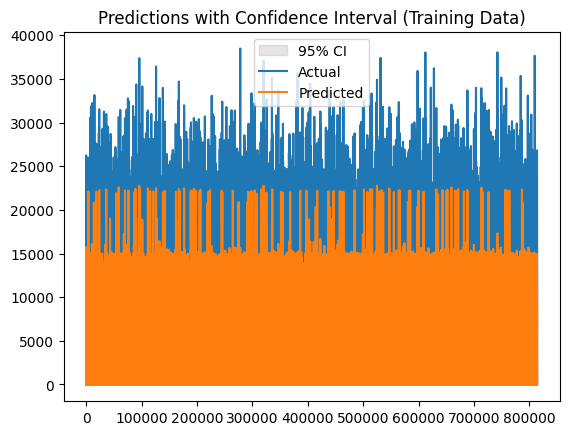

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Bootstrapping for confidence intervals
def bootstrap_predictions(model, X, y, n_iterations=10):
    predictions = []
    for _ in range(n_iterations):
        indices = np.random.choice(range(len(X)), len(X), replace=True)
        X_sample, y_sample = X[indices], y.iloc[indices]

        # Provide a validation set (e.g., a portion of X_sample)
        X_train_bootstrap, X_val_bootstrap, y_train_bootstrap, y_val_bootstrap = train_test_split(
            X_sample, y_sample, test_size=0.2, random_state=42  # Adjust test_size as needed
        )

        model.fit(X_train_bootstrap, y_train_bootstrap, eval_set=[(X_val_bootstrap, y_val_bootstrap)],
                  early_stopping_rounds=10, verbose=False)  # Add eval_set and other parameters
        predictions.append(model.predict(X))
    return np.array(predictions)

# Use X_train_scaled and y_train, which are NumPy arrays
bootstrapped_predictions = bootstrap_predictions(regressor, X_train_scaled, y_train)

# Calculate confidence intervals
lower_bound = np.percentile(bootstrapped_predictions, 2.5, axis=0)
upper_bound = np.percentile(bootstrapped_predictions, 97.5, axis=0)

# Visualize - adjust X and y values
plt.fill_between(range(len(y_train)), lower_bound, upper_bound, color='gray', alpha=0.2, label='95% CI')
plt.plot(range(len(y_train)), y_train, label='Actual')
plt.plot(range(len(y_train)), bootstrapped_predictions.mean(axis=0), label='Predicted')  # Use predictions from the original model
plt.legend()
plt.title("Predictions with Confidence Interval (Training Data)")
plt.show()

## Build a Deep Learning Model with LSTM

## Transform the dataset into a supervised learning format.

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Sort data by Store and Date (ensure chronological order)
data = data.sort_values(['Store', 'DayOfWeek'])

# Create lag features for previous sales (e.g., lag of 1, 2, and 3 days)
data['Lag_1'] = data['Sales'].shift(1)
data['Lag_2'] = data['Sales'].shift(2)
data['Lag_3'] = data['Sales'].shift(3)

# Select relevant features for LSTM
features = ['Lag_1', 'Lag_2', 'Lag_3', 'Promo', 'SchoolHoliday', 'CompetitionDistance']
target = 'Sales'

X = data[features]
y = data[target]

# Scale features to range (-1, 1)
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape data for LSTM (samples, time steps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))


## Define and Train the LSTM Model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train-test split
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_scaled[:train_size], y_scaled[train_size:]

# Train the model
history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 106s 4ms/step - loss: nan - val_loss: nan
Epoch 2/20
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 128s 4ms/step - loss: nan - val_loss: nan
Epoch 3/20
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 139s 3ms/step - loss: nan - val_loss: nan
Epoch 4/20
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 145s 4ms/step - loss: nan - val_loss: nan
Epoch 5/20
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 145s 4ms/step - loss: nan - val_loss: nan


## Evaluate the Model